In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

In [ ]:
imdb_path = r'C:\Users\espym.LAPTOP-41F90NSA\Desktop\zippedData\im.db\im.db'
conn = sqlite3.connect(imdb_path)


In [ ]:
file_path1 = r'C:\Users\espym.LAPTOP-41F90NSA\projects\Movie_Project-1\tmdb.movies.csv.gz'
tmdbDF = pd.read_csv(file_path1)

In [ ]:
filepath2 = r'C:\Users\espym.LAPTOP-41F90NSA\projects\Movie_Project-1\tn.movie_budgets.csv.gz'
tn_movieDF = pd.read_csv(filepath2)

In [ ]:
filepath3 = r'C:\Users\espym.LAPTOP-41F90NSA\projects\Movie_Project-1\rt.movie_info.tsv.gz'
movie_infoDF = pd.read_csv(filepath3, delimiter='\t')

In [ ]:
filepath4 =r'C:\Users\espym.LAPTOP-41F90NSA\projects\Movie_Project-1\rt.reviews.tsv.gz'
reviewsDF = pd.read_csv(filepath4, delimiter='\t', encoding='latin-1')

## Preview of Information in the data

Here we just want to have a look at whats contained in the IMDB dataset and just have a proper feel of whats contained in the dataset

In [ ]:
#from the imdb database we first want to know the names and number of the tables.
query0 = ("""
    SELECT name
    AS 'Table_Name'
    FROM sqlite_master
    WHERE type = 'table'
;
""")
pd.read_sql(query0,conn)

In [ ]:
# checking for the information contained in the movie basics table
query1 = ("""
    SELECT * 
    FROM movie_basics
    ;
          """)
pd.read_sql(query1,conn).head()

In [ ]:
# In the reviews dataframe we will check for the last values
pd.read_sql(query1,conn).tail()

In [ ]:
#check the shape of the dataframe 
pd.read_sql(query1,conn).shape

In [ ]:
#check for all the columns in the DF
pd.read_sql(query1,conn).columns

In [ ]:
pd.read_sql(query1,conn).info()

In [ ]:
pd.read_sql(query1,conn).describe()

In [ ]:
# Checking for the unique genres
df = pd.read_sql(query1,conn)
genre_column = df['genres']
df['genres'].unique()

Now that we have a feel of the movie_basics, well also explore movie_ratings table

In [ ]:
query2 = ("""
    SELECT * 
    FROM movie_ratings
    ;
        """)
pd.read_sql(query2,conn).head()

In [ ]:
pd.read_sql(query2,conn).tail()

In [ ]:
pd.read_sql(query2,conn).info()

In [ ]:
pd.read_sql(query2,conn).describe()

In [ ]:
# previwing the third dataset Movie budgets
tn_movieDF.head()

In [ ]:
tn_movieDF.tail()

In [ ]:
tn_movieDF.info()

In [ ]:
tn_movieDF.count()

## Data Cleaning

Now that we have a feeling of the data, we will now combine the two tables i.e movie_basics and movie_ratings using their primary key movie_id

In [ ]:
#Joining the tables using the movie_id column
query3 = ("""
SELECT movie_id, primary_title,start_year,runtime_minutes,genres,averagerating AS 'movie_rating'
FROM movie_basics
JOIN movie_ratings
USING (movie_id)
;
""")
df = pd.read_sql(query3,conn)

In [ ]:
df.info()

We will now go ahead and clean the dataset to remove the missing values in the dataframe. The columns runtime_minutes and genres appear to having missing values

In [ ]:
df.isnull().sum()

In [ ]:
#checking for the percentage of missing values in the dataframe
#checking for the sum of null values
null_count = df.isnull().sum()


In [ ]:
#checking for all the values
non_null_count = df.shape[0]

In [ ]:
#checking the percentage of the null values to determine if to drop them
null_percentage = (null_count / non_null_count) * 100
print(null_percentage)

In [ ]:
#The null values take a minimal percentage of the total values and can be droppped
df.dropna(inplace=True)
df.shape

In [ ]:
#checking null values in the other dataframe
budgetDF = tn_movieDF
budgetDF.info()

The budget dataframe contains no null values

Conversion of datatypes

In [ ]:
budgetDF.info()

In [ ]:
#The prodution_budget,domestic_gross and worldwide_gross are denoted as objects and we need them as float in order to mathematical computations
budgetDF['production_budget'] = budgetDF['production_budget'].str.replace('$', '').str.replace(',', '').astype(float)
budgetDF['domestic_gross'] = budgetDF['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(float)
budgetDF['worldwide_gross'] = budgetDF['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)

Checking for duplicates 


In [ ]:
df.duplicated().sum()

In [ ]:
budgetDF.duplicated().sum()

From both the datasets, there are no duplicated values

Checking for data consistency

In [ ]:
df.describe()

From this we have a few issues in regards to runtime
1. The minimum runtime is 3 minutes which is quite low to meet a movie threshold
2. The maximum runtime is 51420 which an extreme value

filtering the values to include a minimum threshold of 20 minutes and 180 minutes 

In [ ]:
clean_runtime = df[(df['runtime_minutes'] >= 20) & (df['runtime_minutes'] <= 180)]
sum_of_movies_within_threshold = len(clean_runtime)
print('The movies within the threshold are:', sum_of_movies_within_threshold)

In [ ]:
df = df[(df['runtime_minutes'] >= 20) & (df['runtime_minutes'] <= 180)]

In [ ]:
df.describe()

In [ ]:
budgetDF.info()

We have an issue with the release date as its an object and its needed to be in date format

In [ ]:
#conversion of release date from object to datetime
budgetDF['release_date'] = pd.to_datetime(budgetDF['release_date'])

In [ ]:
budgetDF.info()

In [ ]:
#checking for the duration of info in the budget dataframe
start_date = budgetDF['release_date'].min()
end_date = budgetDF['release_date'].max()

print(f'the start date is {start_date} and the end date is {end_date}')


From this we see the first date is 1915 which is significantly a long time ago and the film and production industry has changed in one way or another. We will now convert the dataframe to start in the the year 2000 and end in 2019 as 2020 has no gross earnings

In [ ]:
start_date = pd.to_datetime('2000-1-1 00:00:00')
end_date = pd.to_datetime('2019-12-31 00:00:00')
budgetDF = budgetDF[(budgetDF['release_date'] >= start_date) & (budgetDF['release_date'] <= end_date)]

## Explarotary Analysis

In [ ]:
#checking for the year and duration of the release dates 
start_date = df['start_year'].min()
end_date = df['start_year'].max()
period_taken = end_date - start_date

print('start:', start_date)
print('stop:', end_date)
print('durarion:', period_taken,'years')

In [ ]:
#checking for the duration of info in the budget dataframe
start_date = budgetDF['release_date'].min()
end_date = budgetDF['release_date'].max()
period_taken = end_date -  start_date

print('The start date is', start_date)
print('The end date id', end_date)
print('Period of the dataset is', period_taken)

Univariate Analysis

In [ ]:
df.columns

In [ ]:
df['primary_title'].describe()

In [ ]:
#Checking for the most common genre
df['genres'].describe()


In [ ]:
df['genres'].value_counts()

In [ ]:
budgetDF.columns

In [ ]:
budgetDF['movie'].describe()

Bivariate Analysis

How has the average movie runtime changed over the years

In [ ]:
df.columns

In [ ]:
runtime_changes_over_years = df.groupby('start_year')['runtime_minutes'].mean()
print(runtime_changes_over_years)

In [ ]:
#To visualize this runtime changes
sns.barplot(x='start_year', y='runtime_minutes', data=df)
plt.title('Changes in running time in years')
plt.show()

What is the average movie rating over the years

In [ ]:
df.columns

In [ ]:
average_ratings_over_years = df.groupby('start_year')['movie_rating'].mean().sort_values()
print(average_ratings_over_years)

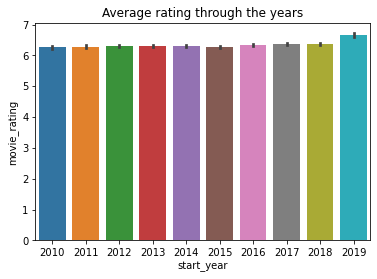

In [750]:
sns.barplot(x='start_year',y='movie_rating',data=df)
plt.title('Average rating through the years')
plt.show()

Checking for the year with the highest average gross earnings

In [ ]:
budgetDF.columns

The release date is inclusive of date and month and for this we just want the years. We will convert the release date to years only

In [ ]:
#conversion to years
budgetDF['release_date'] = budgetDF['release_date'].dt.year

In [752]:
average_earnings = budgetDF.groupby('release_date')['worldwide_gross'].mean().sort_values(ascending=False)
print(average_earnings)

release_date
2018    1.824786e+08
2017    1.692240e+08
2016    1.313614e+08
2012    1.156729e+08
2013    1.107553e+08
2009    1.003943e+08
2019    9.965411e+07
2014    9.911344e+07
2011    9.714671e+07
2004    8.924908e+07
2010    8.843764e+07
2007    8.641767e+07
2015    8.225145e+07
2003    8.209727e+07
2008    8.155407e+07
2001    8.096845e+07
2005    7.888583e+07
2002    7.822510e+07
2006    7.163864e+07
2000    6.891062e+07
Name: worldwide_gross, dtype: float64


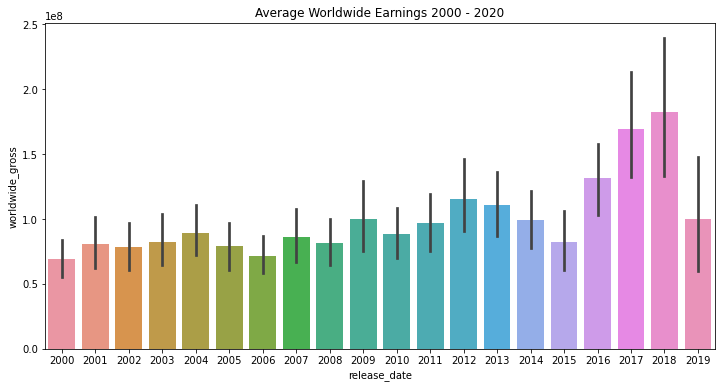

In [751]:
plt.figure(figsize=(12,6))
sns.barplot(x='release_date', y='worldwide_gross',data=budgetDF)
plt.title('Average Worldwide Earnings 2000 - 2020')
plt.show()

Does Running Time affect rating

In [ ]:
df.columns

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='movie_rating',y='runtime_minutes',data=df)
plt.title('relationship btwn rating and runtime')
plt.show()

FInding theres a relationship between budget and worldwide income

In [765]:
budgetDF.columns

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

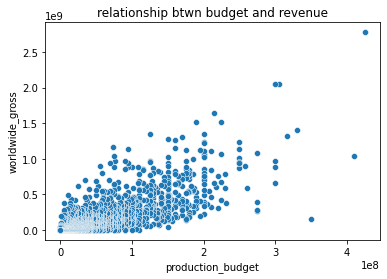

In [767]:
sns.scatterplot(x='production_budget', y='worldwide_gross', data=budgetDF)
plt.title('relationship btwn budget and revenue')
plt.show()